In [3]:
import numpy as np
import transfer_matrix as tm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

###############################################################################
# Define constants to be used in the code.
###############################################################################
 
c      = 2.998e8       # m/s
GHz    = 1e9         # gigaHertz
THz    = 1e12        # teraHertz
deg    = np.pi/180.     # converts degrees to radians.
cm     = 0.01
mm     = 0.001
micron = 1e-6
inch   = 0.0254      # inch to meter conversion.
mil    = 2.54e-5     # mil (0.001") to meter conversion.

###############################################################################
# Parameters 
fhwp = 2. # Hz, freq rotation of the HWP
t_max = (360*np.pi/180)/(2*np.pi*fhwp)
t_range = np.linspace(0,t_max, 281)
nu_range = np.linspace(60.,196.,281)

In [4]:
### Materials
sapphire = tm.material( 3.05, 3.38, 2.3e-4, 1.25e-4, 'Sapphire', materialType='uniaxial')
duroid   = tm.material( 1.41, 1.41, 1.2e-3, 1.2e-3, 'RT Duroid', materialType='isotropic')
mullite = tm.material( 2.52, 2.52, 0.0121, 0.0121, 'Mullite', materialType='isotropic')
epoteck = tm.material( 1.7, 1.7, 0., 0., 'Epoteck', materialType='isotropic')

In [5]:
def AR (duroid_th, epoteck_th, mullite_th, angle1, angle2, angle3) :
    AR = { }
    AR['materials'] = [duroid, epoteck, mullite]
    AR['thickness'] = [duroid_th*tm.mm, epoteck_th*tm.mm, mullite_th*tm.mm]
    AR['angles'] = [angle1*tm.deg,angle2*tm.deg, angle3*tm.deg]
    return AR 

In [6]:
def hwp(th1, th2, th3, angle1, angle2, angle3) :
    hwp = { }
    hwp['materials'] = [sapphire, sapphire, sapphire]
    hwp['thickness'] = [th1*tm.mm, th2*tm.mm, th3*tm.mm]
    hwp['angles'] = [angle1*tm.deg,angle2*tm.deg, angle3*tm.deg]
    return hwp

In [7]:
def delta(thickness, frequency, indexOrdinary, indexExtraordinary):
    return 2*np.pi*thickness*np.abs(indexExtraordinary-indexOrdinary)*frequency/c

def Mgrid():
    # Mueller matrix for a grid
    Mgrid_ = np.zeros((4,4))
    Mgrid_[:2,:2] = 0.5
    return Mgrid_

def Mrot(alpha_):
    # Mueller matrix for a rotation
    Mrot_ = np.eye(4)
    Mrot_[1,1] = np.cos(2*alpha_)
    Mrot_[1,2] = np.sin(2*alpha_)
    Mrot_[2,1] = -np.sin(2*alpha_)
    Mrot_[2,2] = np.cos(2*alpha_)
    return Mrot_

In [8]:
def model_hwp(t_HWP,  a, b, c, phi4, phi2):
    return a+b*np.cos(4*(2*np.pi*fhwp*t_HWP)+4*phi4)+c*np.cos(2*(2*np.pi*fhwp*t_HWP)+2*phi2)

In [30]:
initial_stokes = [1, 0, 0, 0]
final_stokes = np.empty(len(t_range))

In [10]:
class StackCalculator:
    def __init__(self, frequency, time):
        self.frequency = frequency
        self.time = time

    def compute_stack(self, frequency, time, th1, th2, th3, angle1, angle2, angle3, theta, angleIncidence):        
        #build the stack
        ar_dic = AR(0.394, 0.04, 0.212, 0, 0, 0)
        hwp_dic = hwp(th1, th2, th3, angle1, angle2, angle3)
        stack_dic = { }
        stack_dic['materials'] = ar_dic['materials'] + hwp_dic['materials'] + ar_dic['materials'][:-1]
        stack_dic['thickness'] = ar_dic['thickness']+ hwp_dic['thickness'] + ar_dic['thickness'][:-1]
        stack_dic['angles'] = ar_dic['angles'] + hwp_dic['angles'] + ar_dic['angles'][:-1]
        stack_ = tm.Stack(stack_dic['thickness'], stack_dic['materials'], stack_dic['angles'])
        
        # Compute the stack using transfer matrix method
        Mueller_      = np.array(tm.Mueller(stack_, frequency*GHz, angleIncidence*deg, 2*np.pi*fhwp*time, reflected=False))
        Mtot = Mrot(theta).T.dot(Mgrid()).dot(Mueller_).dot(Mrot(theta)).dot(Mgrid())
        
        return Mtot


In [48]:
def phi4(angleIncidence, th1, th2, th3, angle1, angle2, angle3, theta, frequency):
    #phi4_array = np.empty(len(nu_range))
    #build the stack
    ar_dic = AR(0.394, 0.04, 0.212, 0, 0, 0)
    hwp_dic = hwp(th1, th2, th3, angle1, angle2, angle3)
    stack_dic = { }
    stack_dic['materials'] = ar_dic['materials'] + hwp_dic['materials'] + ar_dic['materials'][:-1]
    stack_dic['thickness'] = ar_dic['thickness']+ hwp_dic['thickness'] + ar_dic['thickness'][:-1]
    stack_dic['angles'] = ar_dic['angles'] + hwp_dic['angles'] + ar_dic['angles'][:-1]
    stack_ = tm.Stack(stack_dic['thickness'], stack_dic['materials'], stack_dic['angles'])
    # for k,nu_ in enumerate(nu_range):
    for j,t_ in enumerate(t_range):
        #compute the Mueller matrix for the stack and M_tot
        Mueller_      = np.array(tm.Mueller(stack_, frequency*GHz, angleIncidence*deg, 2*np.pi*fhwp*t_, reflected=False))
        Mtot = Mrot(theta).T.dot(Mgrid()).dot(Mueller_).dot(Mrot(theta)).dot(Mgrid())
        #compute the final stokes vector
        final_stokes_ = Mtot.dot(initial_stokes)[0]
        final_stokes[j] = final_stokes_
        popt, _ = curve_fit(model_hwp, t_range, final_stokes_, bounds=([-1.,-1,-1,-30*deg,0], [1,1,1,30.*deg, 3*np.pi/4]))

    return np.abs(popt[3])/deg


In [51]:
phi4test = phi4(0.394, 0.04, 0.212, 0, 0, 0, 0,0,90)


In [52]:
print(phi4test)

3.580219124796257e-06


In [53]:
#Data
import csv

# Specify the file path
file_path = '/Users/ema/hwp/hwp+cs/data/MF1_AHWP_spectra (2).csv'

# Open the CSV file
with open(file_path, 'r', newline='') as csv_file:
    # Create a CSV reader object
    csv_reader = csv.reader(csv_file)

import pandas as pd

# Specify the file path
file_path = '/Users/ema/hwp/hwp+cs/data/MF1_AHWP_spectra (2).csv'

# Read the CSV file
df = pd.read_csv(file_path)

# Access the desired column
eps = df['modulation efficiency']
eps_err = df['modulation efficiency STD']
freq = df['frequency (GHz)']
phi4_data = df['phase shift (deg)']
phi4_err = df['phase shift STD']

In [54]:
print(phi4_data.shape)

(281,)


In [55]:
def chi2(params, frequency):
     angleIncidence, th1, th2, th3, angle1, angle2, angle3, theta = params
     return sum((phi4_data - phi4(frequency, angleIncidence, th1, th2, th3, angle1, angle2, angle3, theta))**2)

In [45]:
chi2(90, [0.394, 0.04, 0.212, 0, 0, 0, 0,0])

27824.07590544709

In [47]:
from scipy.optimize import minimize
chi = lambda *args: -chi2(*args)
initial = np.array([0, 3.75, 3.75, 3.75, 0, 56., 0, 0]) + 0.1 * np.random.randn()
soln = minimize(chi, initial, args=(nu_range))
res = soln

ValueError: too many values to unpack (expected 8)

In [43]:


# Define the initial guess for the parameters
initial_guess = np.array([0, 3.75, 3.75, 3.75, 0, 56., 0, 0])

# Define the bounds for the parameters
bounds = [(0, 90.), (0, 5), (0, 5), (0, 5), (0, 90), (0, 90), (0, 90)]

# Minimize the chi2 function
result = minimize(chi2, initial_guess) #args=(0.394, 0.04, 0.212, 0, 0, 0, 0), bounds=bounds)

# Get the optimized parameters
optimized_params = result.x


KeyboardInterrupt: 

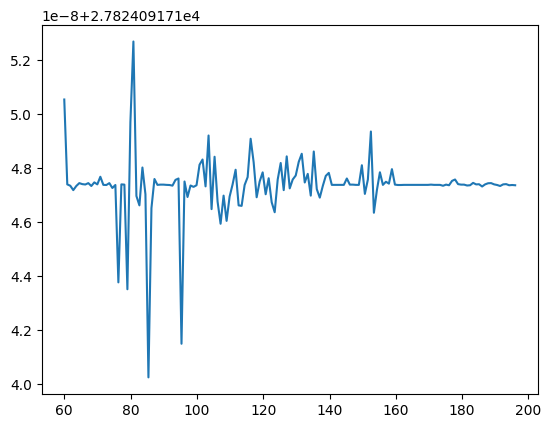

In [ ]:
plt.plot(nu_range, chi2_list)